In [111]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [112]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [113]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [114]:
print (str(n_users) + ' users')
print (str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Sparsity: 6.30%


In [115]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [116]:
train, test = train_test_split(ratings)

In [117]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ( 'Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ( 'Train mse: ' + str(self.train_mse[-1]))
                print ( 'Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [119]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [120]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

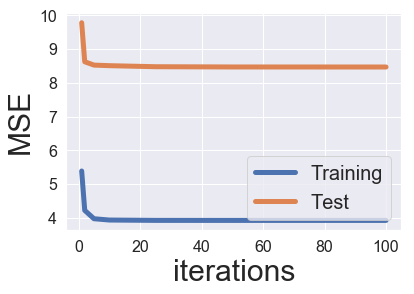

In [12]:
plot_learning_curve(iter_array, MF_ALS)


In [122]:
!head -5 u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


In [123]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ( 'Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [124]:
best_als_model = ExplicitMF(ratings, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1)
best_als_model.train(100)

In [125]:


def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_sim = cosine_similarity(best_als_model)

In [129]:
idx_to_movie = {}


with open('u.item', encoding = "ISO-8859-1") as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]
        
def display_top_k_movies(similarity, movie_idx):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    k_ctr = 0 
    i = 1
    print(movie_idx)
    print ("users who like ", idx_to_movie[movie_idx])
    print(" also like: ")
    while k_ctr < 5:
        movie = idx_to_movie[movie_indices[i]]
        print(movie_indices[i], movie)
        k_ctr += 1
        i += 1
def get_top_k_list(similarity, movie_idx):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    k_ctr = 0 
    i = 1
    topKList = []
    while k_ctr < 5:
        topKList.append(movie_indices[i])
        k_ctr += 1
        i += 1
    return "[{0}]".format(','.join(str(e) for e in topKList))

    
    


In [197]:
print (als_sim)
get_top_k_list(als_sim,4)
#display_top_k_movies(als_sim, 4)


[[ 1.          0.35832838  0.50077822 ... -0.05195545  0.1277171
  -0.04118441]
 [ 0.35832838  1.          0.50272942 ...  0.01630828  0.79393385
   0.32817004]
 [ 0.50077822  0.50272942  1.         ... -0.02178238  0.12842611
   0.37698945]
 ...
 [-0.05195545  0.01630828 -0.02178238 ...  1.         -0.13213206
  -0.30733179]
 [ 0.1277171   0.79393385  0.12842611 ... -0.13213206  1.
   0.45037718]
 [-0.04118441  0.32817004  0.37698945 ... -0.30733179  0.45037718
   1.        ]]


'[217,1134,580,1206,1045]'

In [190]:
import requests
import json
from time import sleep

headers= {'Content-Type': 'application/json'}


def getElasticIndex(movie_id):
    url = 'http://localhost:9200/items/_search'
    data = '''{{ "stored_fields" : ["movie id"],"query" : {{ "term" : {{ "movie id": {0} }} }} }} '''
    response = requests.post(url,headers=headers, data=data.format(movie_id))
    if(response.ok):
        jdata = json.loads(response.content)
    else:
        response.raise_for_status()
    return jdata['hits']['hits'][0]['_id']


def updateElasticLikeMovies(elasticId, movie_id):
    url = "http://localhost:9200/items/_doc/{0}/_update".format(elasticId)
    likeMovieList = get_top_k_list(als_sim,movie_id)
    data = '''{{"script" : "ctx._source.likeMovies = {0} "}}'''.format(likeMovieList)
    skipped= 1
    response = ''
    if(elasticId not in elasticUpdated):
        response = requests.post(url,headers=headers, data=data)
        skipped = 0
        if(response.ok):
            elasticUpdated[elasticId]=1
            print (elasticId, data, response, "skipped: ",skipped)
        else: 
            print('.', end='')
#             print("retry")
#             sleep(5)
#             response = requests.post(url,headers=headers, data=data) #retry
#             if(response.ok):
#                 elasticUpdated[elasticId]=1
#    else: 
#         print ()
            
        
   
    

In [134]:
elasticIndex = {}

#elastic_index = 
for i in range(1,1682):
    key = getElasticIndex(i)
    if key in elasticIndex:
        print("error")
    else:
        elasticIndex[key] = i
    

In [193]:
while(len(elasticUpdated) < len(elasticIndex)):
    current = len(elasticUpdated)
    for key in elasticIndex.keys():
        updateElasticLikeMovies(key, elasticIndex[key] )
    print (current, len(elasticUpdated)-current, "more done")
    sleep(10)
    

n3UA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [1510,340,901,344,905] "} <Response [200]> skipped:  0
oHUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [351,690,1291,751,349] "} <Response [200]> skipped:  0
oXUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [339,301,304,886,1295] "} <Response [200]> skipped:  0
o3UA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [335,269,1381,884,1416] "} <Response [200]> skipped:  0
pHUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [1378,903,1461,313,765] "} <Response [200]> skipped:  0
pnUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [359,1235,1234,907,1393] "} <Response [200]> skipped:  0
qHUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [904,347,352,338,262] "} <Response [200]> skipped:  0
q3UA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [899,344,1590,310,901] "} <Response [200]> skipped:  0
rHUA32UBEugMWDHZfYlu {"script" : "ctx._source.likeMovies = [359,352,262,913,361] "} <

.................................................................................................................vHUA32UBEugMWDHZfYpx {"script" : "ctx._source.likeMovies = [453,699,1420,769,1146] "} <Response [200]> skipped:  0
......................................................................................................................................................................................................................................................................................................1198 76 more done
FHUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [1161,1375,1087,803,991] "} <Response [200]> skipped:  0
FnUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [967,756,623,490,1443] "} <Response [200]> skipped:  0
GHUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [1474,970,112,1194,729] "} <Response [200]> skipped:  0
...................................................................................................................

.........................................................................................................................................................................................................................................................................................................................................................1303 3 more done
OHUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [400,39,382,77,1057] "} <Response [200]> skipped:  0
OXUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [1264,1294,936,1190,1104] "} <Response [200]> skipped:  0
OnUA32UBEugMWDHZfYpv {"script" : "ctx._source.likeMovies = [7,152,190,172,215] "} <Response [200]> skipped:  0
..........................................................................................................................................................................................................................................................................................................

...................................................................................................................................................................................................................................................................................................................................................1339 3 more done
ZXUA32UBEugMWDHZfYpw {"script" : "ctx._source.likeMovies = [1513,533,261,1143,1225] "} <Response [200]> skipped:  0
Z3UA32UBEugMWDHZfYpw {"script" : "ctx._source.likeMovies = [595,150,14,24,1327] "} <Response [200]> skipped:  0
aHUA32UBEugMWDHZfYpw {"script" : "ctx._source.likeMovies = [1201,1367,1067,148,235] "} <Response [200]> skipped:  0
............................................................................................................................................................................................................................................................................................................

.........................................................................................................................UXUA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [1369,1531,1417,1318,1085] "} <Response [200]> skipped:  0
.....................................................................................................................................................................................1376 3 more done
kXUA32UBEugMWDHZfYpx {"script" : "ctx._source.likeMovies = [494,1454,1049,611,1123] "} <Response [200]> skipped:  0
k3UA32UBEugMWDHZfYpx {"script" : "ctx._source.likeMovies = [1009,1072,1102,1069,1222] "} <Response [200]> skipped:  0
.................................................................................................MnUA32UBEugMWDHZfYtz {"script" : "ctx._source.likeMovies = [1335,408,1278,928,1094] "} <Response [200]> skipped:  0
....................................................................................................................

.......................................................................................................................................................................................................................................................................1415 3 more done
znUA32UBEugMWDHZfYpy {"script" : "ctx._source.likeMovies = [319,852,853,843,932] "} <Response [200]> skipped:  0
0HUA32UBEugMWDHZfYpy {"script" : "ctx._source.likeMovies = [916,790,1593,1439,1178] "} <Response [200]> skipped:  0
0XUA32UBEugMWDHZfYpy {"script" : "ctx._source.likeMovies = [863,1101,865,273,814] "} <Response [200]> skipped:  0
....................................................................................................................................................................................................................................................................1418 3 more done
0nUA32UBEugMWDHZfYpy {"script" : "ctx._source.likeMovies = [1670,1432,890,1061,1294] "} <Response [2

..............................................................................................................................................................................................................................1456 3 more done
BHUA32UBEugMWDHZfYty {"script" : "ctx._source.likeMovies = [934,15,1067,1250,250] "} <Response [200]> skipped:  0
BXUA32UBEugMWDHZfYty {"script" : "ctx._source.likeMovies = [1349,1330,1435,1271,1405] "} <Response [200]> skipped:  0
BnUA32UBEugMWDHZfYty {"script" : "ctx._source.likeMovies = [1126,1292,1678,1679,1677] "} <Response [200]> skipped:  0
...........................................................................................................................................................................................................................1459 3 more done
DXUA32UBEugMWDHZfYty {"script" : "ctx._source.likeMovies = [1313,1436,801,778,1187] "} <Response [200]> skipped:  0
DnUA32UBEugMWDHZfYty {"script" : "ctx._source.likeMovies = 

...................................................................................................................................................................................1500 2 more done
RXUA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [1306,1472,1307,1529,841] "} <Response [200]> skipped:  0
RnUA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [1307,1305,1576,1545,1547] "} <Response [200]> skipped:  0
R3UA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [1306,1567,1570,1560,1561] "} <Response [200]> skipped:  0
................................................................................................................................................................................1502 3 more done
S3UA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [1119,1510,869,1161,1489] "} <Response [200]> skipped:  0
TXUA32UBEugMWDHZfYt0 {"script" : "ctx._source.likeMovies = [26,801,778,807,1187] "} <Response [200]> skipped:  0
T3UA32UBEugMWDHZfYt0 {"scrip

.....................................................................................................................................1546 2 more done
onUA32UBEugMWDHZfYt1 {"script" : "ctx._source.likeMovies = [328,878,1024,325,688] "} <Response [200]> skipped:  0
o3UA32UBEugMWDHZfYt1 {"script" : "ctx._source.likeMovies = [386,971,952,1167,963] "} <Response [200]> skipped:  0
pHUA32UBEugMWDHZfYt1 {"script" : "ctx._source.likeMovies = [548,726,43,971,1118] "} <Response [200]> skipped:  0
..................................................................................................................................1548 3 more done
pXUA32UBEugMWDHZ-Itx {"script" : "ctx._source.likeMovies = [862,637,969,1120,165] "} <Response [200]> skipped:  0
pnUA32UBEugMWDHZ-Itx {"script" : "ctx._source.likeMovies = [535,1461,1194,1254,1004] "} <Response [200]> skipped:  0
p3UA32UBEugMWDHZ-Itx {"script" : "ctx._source.likeMovies = [60,59,58,17,463] "} <Response [200]> skipped:  0
......................

.................................................................................1598 2 more done
8nUA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [1106,1515,1191,1146,1444] "} <Response [200]> skipped:  0
83UA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [842,1029,138,399,767] "} <Response [200]> skipped:  0
9HUA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [1494,1320,1491,1493,1485] "} <Response [200]> skipped:  0
..............................................................................1600 3 more done
9XUA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [1082,772,773,815,799] "} <Response [200]> skipped:  0
93UA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [1026,1480,1490,1497,1485] "} <Response [200]> skipped:  0
-HUA32UBEugMWDHZ-Ity {"script" : "ctx._source.likeMovies = [1287,1487,1026,1490,1497] "} <Response [200]> skipped:  0
...........................................................................1603 3 more done
-3UA32UBEugMWDH

fHUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1611,1292,1623,1624,1612] "} <Response [200]> skipped:  0
fXUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1653,1660,1607,171,173] "} <Response [200]> skipped:  0
...................1660 2 more done
f3UA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1253,686,747,1282,1088] "} <Response [200]> skipped:  0
gHUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1477,1442,1041,1423,1303] "} <Response [200]> skipped:  0
gXUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1671,112,1154,1655,1192] "} <Response [200]> skipped:  0
................1662 3 more done
gnUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1318,1367,148,1627,1165] "} <Response [200]> skipped:  0
hXUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [1614,1176,1273,1033,390] "} <Response [200]> skipped:  0
..............1665 2 more done
hnUA32UBEugMWDHZ-Ixz {"script" : "ctx._source.likeMovies = [547,1115,433,1121,444

In [204]:
for i in range(1547,1548):
    print('''{{"script" : "ctx._source.likeMovies = {0} "}}'''.format(get_top_k_list(als_sim,i)))
  

{"script" : "ctx._source.likeMovies = [1545,1556,1558,1560,1561] "}


In [18]:
a = np.array([[1, 2], [3, 4]])
b1 = np.sqrt(np.diagonal(a))
b = np.array([np.sqrt(np.diagonal(a))])


print(a/b1)
print (a/b/b.T)

[[1. 1.]
 [3. 2.]]
[[1.  1. ]
 [1.5 1. ]]


In [19]:
als_sim


array([[ 1.        ,  0.35832838,  0.50077822, ..., -0.05195545,
         0.1277171 , -0.04118441],
       [ 0.35832838,  1.        ,  0.50272942, ...,  0.01630828,
         0.79393385,  0.32817004],
       [ 0.50077822,  0.50272942,  1.        , ..., -0.02178238,
         0.12842611,  0.37698945],
       ...,
       [-0.05195545,  0.01630828, -0.02178238, ...,  1.        ,
        -0.13213206, -0.30733179],
       [ 0.1277171 ,  0.79393385,  0.12842611, ..., -0.13213206,
         1.        ,  0.45037718],
       [-0.04118441,  0.32817004,  0.37698945, ..., -0.30733179,
         0.45037718,  1.        ]])